In [7]:
import os
import numpy as np
import pandas as pd
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory


# filename
temp_dir = TemporaryDirectory()
sim_ws = os.path.join(temp_dir.name)
sim_name = "IdealModel1"
# real_lnK = np.load("./data/real_lnK.npy")
def plotmodelmap(mymodel):
    import matplotlib.pyplot as plt

    modelmap = flopy.plot.PlotMapView(model=mymodel, layer=0)
    grid = modelmap.plot_grid()
    plt.xlabel("Lx (m)", fontsize=14)
    plt.ylabel("Ly (m)", fontsize=14)
    plt.title("Grid", fontsize=15, fontweight="bold")
    plt.show()

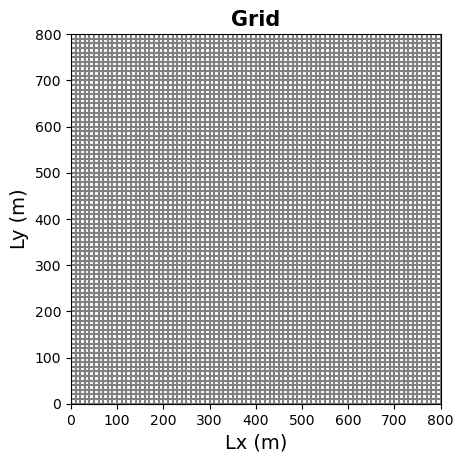

FloPy is using the following executable to run the model: C:\Users\ART\AppData\Local\flopy\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: SM_flow.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/06/20 16:20:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time

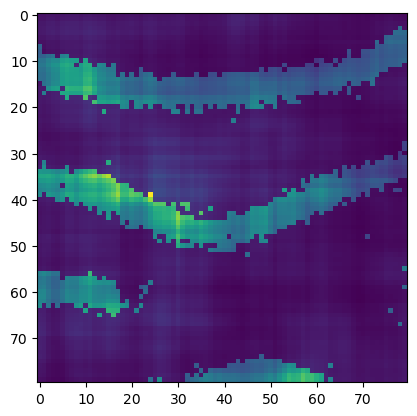

In [8]:
import os
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

# filename
temp_dir = TemporaryDirectory()
sim_ws_1 = os.path.join(temp_dir.name)
sim_name = "modelwithmt3d"


# def get_conc_valid(lnK: np.array, idx_conc_ctrl: list) -> (np.ndarray, np.ndarray):
# """
# 获得浓度控制井处的浓度时间序列和所有时刻的浓度场
# 这个模型与本项目使用的水流模型不同，因为我设置的水流模型中没有溶质运移，
# 现在是为了对比反演效果的好坏，在原来的水流模型的基础上添加了溶质运移，
# 应力期的设置变成两个应力期水流都是稳态的，溶质是非稳态的，第一个应力期200天，第二个应力期300天，
# 在整个模拟期右边界持续抽水，原来是只在第一个应力期的右边界抽水，第二个应力期的右边界不抽水。
# :param lnK: 场地的对数渗透系数, shape (6400,)
# :param idx_conc_ctrl: 浓度控制井的索引值
# :return: 浓度控制点的浓度时间序列，shape (51, 3)，我设置了3个浓度控制井，保存了51个时刻的浓度
#          所有时刻的浓度场，shape (51, 1, 80, 80)
# """

# 1. MODFLOW模型
name_flow = "SM_flow"
workspace = "D:/mt3d_cache"
mf = flopy.modflow.Modflow(
    modelname=name_flow,
    version="mf2005",
    exe_name="mf2005.exe",
    model_ws=workspace,
)
####################################################################################################
# 2. 离散DIS
Lx = 800.0  # x 长度
Ly = 800.0  # y 长度
ztop = 1.0  # z 顶部高程
zbot = 0.0  # z 底部高程
nlay = 1  # 含水层层数
nrow = 80  # 行数
ncol = 80  # 列数
delr = Lx / ncol  # x 步长
delc = Ly / nrow  # y 步长
botm = np.linspace(ztop, zbot, nlay + 1)  # z 每一层的底部高程
nper = 2  # 应力期数
perlen = [200, 300]  # 每个应力期的时间长度
nstp = [200, 300]  # 每个应力期的时间步数
steady = [True, True]  # 每个应力期是否稳态
# Unit System
itmuni = 4  # time units (4=days, 1=seconds)
lenuni = 2  # lenght units (2=meters, 3=centimeters)
dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    top=ztop,
    botm=botm[1:],
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    steady=steady,
    itmuni=itmuni,
    lenuni=lenuni,
)
plotmodelmap(mf)
###################################################################################################
# 3. 基础包BAS
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1  # 最左边的列是常水头边界
strt = np.zeros((nlay, nrow, ncol), dtype=np.float32)  # 初始水头为0

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
##################################################################################################
# 4. LPF
lnK = np.load("./lnK/lnK_real.npy")
vka = 10  # 当layvka>0时，vka表示水平渗透系数和垂直渗透系数的比值
# note 读取模型的渗透系数，三维数组(nlay, nrow, ncol)，注意读取的是lnK需要转换为K
hk = np.exp(lnK.reshape((nlay, nrow, ncol)))
# 水平各项异性默认为1，贮水率使用默认值。
lpf = flopy.modflow.ModflowLpf(mf, laytyp=0, hk=hk, layvka=1, vka=vka)
plt.imshow(hk[0])
##################################################################################################
# 5. CHD 常水头边界
shead = 0.0  # 应力期开始时的水头
ehead = 0.0  # 应力期结束时的水头
bound_sp1 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, shead, ehead])
# 应力期的数据少于应力期数时，flopy会自动复制最后一个应力期的数据，一直用到模拟结束
stress_period_data = {0: bound_sp1}
# Create the flopy chd object
chd = flopy.modflow.ModflowChd(mf, stress_period_data=stress_period_data)
################################################################################################
# 6. 通过在右边界设置一排井来表示指定流量边界
pumping_rate1 = -20.0
pumping_rate2 = -20.0
wel_sp1 = []
for ir in range(nrow):
    wel_sp1.append([0, ir, ncol - 1, pumping_rate1])

wel_sp2 = []
for ir in range(nrow):
    wel_sp2.append([0, ir, ncol - 1, pumping_rate2])

stress_period_data = {0: wel_sp1, 1: wel_sp2}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)
########################################################################################
# 7. 与MT3DMS链接
lmt = flopy.modflow.ModflowLmt(mf, output_file_name="mt3d_link.ftl")
########################################################################################
# 8. OC
# 每个时间步结束保存水头
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head"]
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data, compact=True)
###############################################################################################
# 9. PCG 求解器
pcg = flopy.modflow.ModflowPcg(mf)

# 写入输入文件
mf.write_input()
# 尝试删除输出文件，防止使用之前的旧文件
try:
    os.remove(os.path.join(workspace, name_flow + ".hds"))
except FileNotFoundError:
    pass
# 运行水流模型
success, mfoutput = mf.run_model(silent=False)
assert success, "MODFLOW did not terminate normally!"

[[[    0.         -13.977318   -27.215496 ... -1392.3949   -1420.0674
   -1455.1891  ]
  [    0.         -14.007292   -27.24415  ... -1388.8745   -1413.6995
   -1445.9374  ]
  [    0.         -14.037306   -27.269226 ... -1383.1818   -1401.7325
   -1429.7623  ]
  ...
  [    0.         -12.42697    -26.739141 ... -1585.858    -1617.8221
   -1647.0345  ]
  [    0.         -12.601601   -27.061926 ... -1584.694    -1616.459
   -1645.5568  ]
  [    0.         -12.693041   -27.234148 ... -1584.0797   -1615.701
   -1644.6174  ]]]


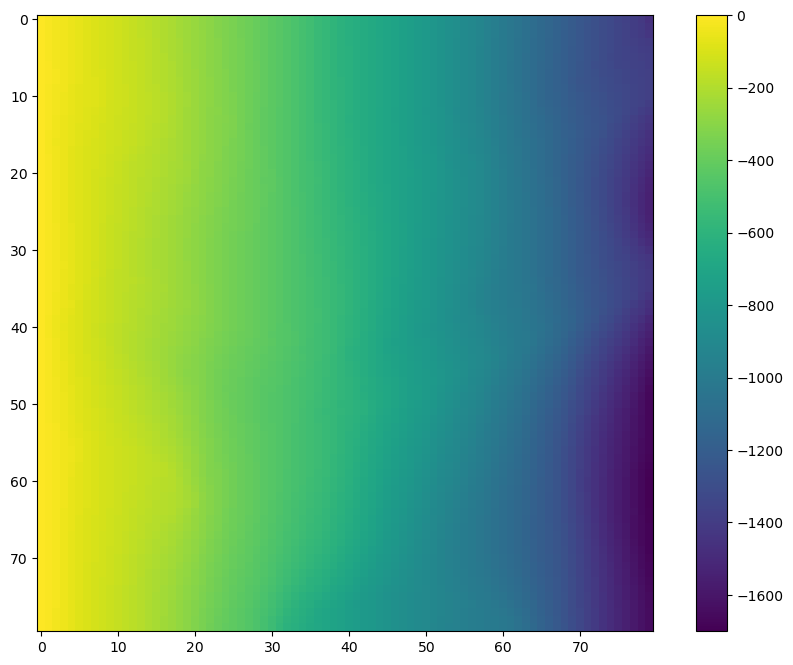

In [9]:
hds = flopy.utils.binaryfile.HeadFile(os.path.join(workspace, name_flow + ".hds"))

hds = hds.get_data()
# df = pd.DataFrame(hds.get_data())  # shape (101, 1, 80, 80)，分别是时间、层、行、列
# print(df)
# 获取水头验证井处的水头时间序列
# head_series = hds.get_ts(idx_head_ctrl)  # shape (101, 4)，第一列是时间
plt.figure(figsize=(11, 8))
plt.imshow(hds[0])
plt.colorbar()
print(hds)
# 创建3d绘图区域
# ax = plt.axes(projection="3d")
# 从三个维度构建
# 调用 ax.plot3D创建三维线图
# ax.plot3D(hds, "gray")
# ax.set_title("3D line plot")
# plt.show()

In [10]:
"""****************************************************************************************
                                            MT3D-USGS
*****************************************************************************************"""

# 1. MT3D-USGS
name_mt3d = "SM_trans"
workspace = "D:/mt3d_cache"
mt = flopy.mt3d.Mt3dms(
    modelname=name_mt3d,
    model_ws=workspace,
    version="mt3d-usgs",
    exe_name="mt3dusgs.exe",
    modflowmodel=mf,
)

###############################################################################################
# 2. BTN file
nprs = 1  # npr > 0 表示将在 timprs 中指定的时刻保存结果，如果不指定，则默认保存每个应力期结束时的浓度
timprs = list(range(0, 500 + 10, 10))  # 保存浓度的时刻
icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)
btn = flopy.mt3d.Mt3dBtn(
    mt,
    sconc=0.0,
    prsity=0.3,
    thkmin=0.01,
    munit="G",
    nprs=nprs,
    timprs=timprs,
    icbund=icbund,
    mxstrn=1000,
)

###############################################################################################
# 3. ADV file 对流
mixelm = -1  # Third-order TVD scheme (ULTIMATE)
percel = 1  # Courant number PERCEL is also a stability constraint
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=percel)

###############################################################################################
# 4. DSP file 弥散
al = 40  # longitudinal dispersivity 是弥散度，单位与长度单位相同
dmcoef = 0  # effective molecular diffusion coefficient，设置为0表示不考虑分子扩散
trpt = (
    1 / 10
)  # ratio of the horizontal transverse dispersivity to the longitudinal dispersivity
trpv = (
    1 / 10
)  # ratio of the vertical transverse dispersivity to the longitudinal dispersivity
dsp = flopy.mt3d.Mt3dDsp(mt, al=al, dmcoef=dmcoef, trpt=trpt, trpv=trpv)

###############################################################################################
# 5. GCG file 求解器
mxiter = 1  # Maximum number of outer iterations，一般设置为1
iter1 = 50  # Maximum number of inner iterations，默认值就是50
isolve = 1  # Preconditioner = 1 Jacobi，加速方案的预条件选择
gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=mxiter, iter1=iter1, isolve=isolve)

###############################################################################################
# 6. SSM file 源汇项
itype = 15
# """对于大多数类型的源，CSS被解释为以单位体积质量为单位的源浓度(ML-3)，
# 当它乘以流量模型中相应的流量(L3T-1)时，就得到了源的质量加载速率(MT-1)。
# 对于特殊类型的源(ITYPE = 15)， CSS直接作为源的质量加载速率(MT-1)，这时流量模型中不需要流量。"""
mxss = 300  # Maximum number of sources and sinks

dtype = np.dtype(
    [("k", "<i8"), ("i", "<i8"), ("j", "<i8"), ("css", "<f4"), ("itype", "<i8")]
)

flux = [300.0, 0.0]  # 源汇项的质量加载速率
# 设置3个点状污染源
idx_inj_well = [(0, 14, 14), (0, 44, 14), (0, 74, 14)]

ssm_data = {}
for kper in range(nper):
    ssm_data[kper] = [
        (0, 14, 14, flux[kper], itype),
        (0, 44, 14, flux[kper], itype),
        (0, 74, 14, flux[kper], itype),
    ]

ssm = flopy.mt3d.Mt3dSsm(mt, mxss=mxss, stress_period_data=ssm_data, dtype=dtype)

###############################################################################################
# Write model input
mt.write_input()

# Try to delete the output files, to prevent use of older files
try:
    os.remove(os.path.join(workspace, "MT3D001.UCN"))
except FileNotFoundError:
    pass

# Run the model
success, buff = mt.run_model(
    silent=False
)  # 虽然运行成功，但success返回值为False，不知道为什么（2023.4.13）

FloPy is using the following executable to run the model: C:\Users\ART\AppData\Local\flopy\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.1.0]   
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: SM_trans.nam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:  0.2766     Total Elapsed Time:  0.27659    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.444      [K,I,J]    1   75   15
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3548      [K,I,J]    1   45   16
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1100      [K,I,J]    1   45   17
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5605E-01  [K,I,J]    1   15   14
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2848E-01  [K,I,J]    1   15   15
 Outer Iter.  1  

[[0.0000000e+00 0.0000000e+00]
 [1.0000000e+01 1.1838558e-10]
 [2.0000000e+01 1.6906411e-05]
 [3.0000000e+01 2.0271768e-03]
 [4.0000000e+01 2.2642944e-02]
 [5.0000000e+01 9.0412334e-02]
 [6.0000000e+01 2.1377273e-01]
 [7.0000000e+01 3.7554559e-01]
 [8.0000000e+01 5.5040711e-01]
 [9.0000000e+01 7.1800923e-01]
 [1.0000000e+02 8.6667287e-01]
 [1.1000000e+02 9.9190712e-01]
 [1.2000000e+02 1.0937315e+00]
 [1.3000000e+02 1.1745384e+00]
 [1.4000000e+02 1.2375823e+00]
 [1.5000000e+02 1.2861831e+00]
 [1.6000000e+02 1.3232752e+00]
 [1.7000000e+02 1.3514543e+00]
 [1.8000000e+02 1.3728129e+00]
 [1.9000000e+02 1.3888910e+00]
 [2.0000000e+02 1.4009573e+00]
 [2.1000000e+02 1.4099743e+00]
 [2.2000000e+02 1.4167123e+00]
 [2.3000000e+02 1.4198053e+00]
 [2.4000000e+02 1.4031256e+00]
 [2.5000000e+02 1.3383677e+00]
 [2.6000000e+02 1.2171818e+00]
 [2.7000000e+02 1.0567507e+00]
 [2.8000000e+02 8.8283318e-01]
 [2.9000000e+02 7.1595126e-01]
 [3.0000000e+02 5.6787825e-01]
 [3.1000000e+02 4.4312444e-01]
 [3.2000

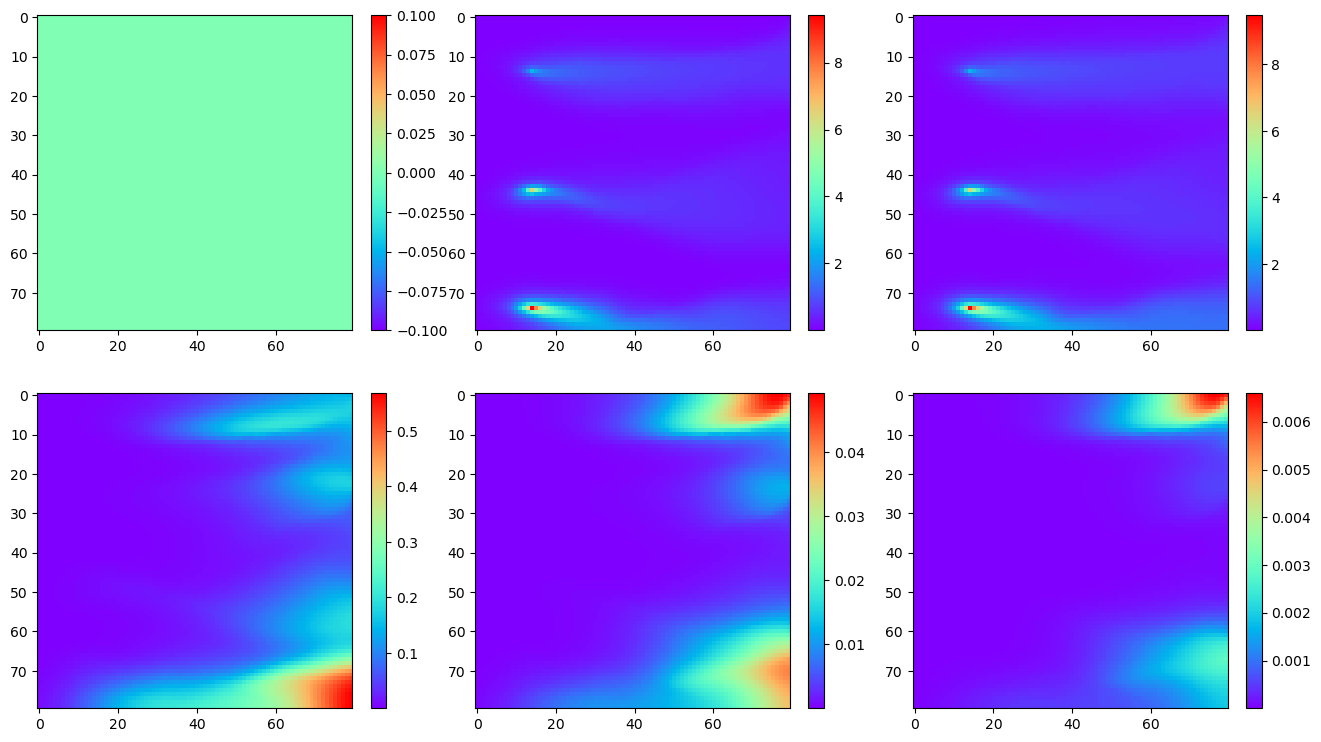

In [11]:
##########################################################################################################
# 读取浓度控制点的浓度数据
concobj = bf.UcnFile(os.path.join(workspace, "MT3D001.UCN"))
conc = flopy.utils.UcnFile(os.path.join(workspace, "MT3D001.UCN"))
# 获取所有时刻的浓度场
conc_field_all_times = (
    concobj.get_alldata()
)  # shape (51, 1, 80, 80) 分别是时间，层，行，列

# 获取浓度控制井处的浓度时间序列
# 第一列是时间，51 是我自己设置的，从0开始每10个时间步保存一次
idx = (0, 79, 79)
conc_ts = concobj.get_ts(idx)  # shape (51, 4)
print(conc_ts)

fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(wspace=0.2)

# nper = 2  # 应力期数
# perlen = [200, 300]  # 每个应力期的时间长度
# nstp = [200, 300]  # 每个应力期的时间步数
# steady = [True, True]  # 每个应力期是否稳态
# the time step and stress period (kstp, kper)
ax0 = fig.add_subplot(2, 3, 1)
im0 = ax0.imshow(conc.get_alldata()[0][0], cmap="rainbow")
ax0 = fig.add_subplot(2, 3, 2)
im1 = ax0.imshow(conc.get_alldata()[10][0], cmap="rainbow")
ax0 = fig.add_subplot(2, 3, 3)
im2 = ax0.imshow(conc.get_alldata()[20][0], cmap="rainbow")
ax0 = fig.add_subplot(2, 3, 4)
im3 = ax0.imshow(conc.get_alldata()[30][0], cmap="rainbow")
ax0 = fig.add_subplot(2, 3, 5)
im4 = ax0.imshow(conc.get_alldata()[40][0], cmap="rainbow")
ax0 = fig.add_subplot(2, 3, 6)
im5 = ax0.imshow(conc.get_alldata()[50][0], cmap="rainbow")
plt.colorbar(im0, fraction=0.05, pad=0.05)
plt.colorbar(im1, fraction=0.05, pad=0.05)
plt.colorbar(im2, fraction=0.05, pad=0.05)
plt.colorbar(im3, fraction=0.05, pad=0.05)
plt.colorbar(im4, fraction=0.05, pad=0.05)
plt.colorbar(im5, fraction=0.05, pad=0.05)